--- 
### Contents

- Step 1. 실험환경 Set-up
    - 거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.
- Step 2. 데이터 준비하기
    - 원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
    - 의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.
- Step 3. 데이터 시각화
- Step 4. ResNet-18 구현
- Step 5. 데이터 imbalance 처리
- Step 6. 모델 훈련
- Step 7. 결과 확인과 시각화

<!--
0. introduce
    1. data discription
    2. task
    3. contents
  
1. data curation
    1. 데이터 load
    2. data distribution 확인
    3. distribution, task에 따른 data preprocessing 결정
    4. data preprocessing

2. build Model
    1. modeling
    2. hyperparameter 설정
    3. training

3. conclusion
    1. test
    2. visualization
    3. summary
    4. reference
-->

---

### 루브릭

|평가문항|	상세기준|
|:---|:---|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|	**모델 학습이 안정적으로 수렴**하는 것을 **시각화**를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|	**regularization, augmentation** 등의 기법의 사용 여부에 따른 모델 성능 측정이 **ablation study 형태**로 체계적으로 수행되었다.|
|3. ResNet 모델을 구현 하였다.|	Resnet 의 **Residual block을 구현**하고 학습의 경우 1에폭만 진행하여도 인정|

---

### 채점 기준
1. 제출(1점)
2. 루브릭(3점)
3. 보고서 양식(1점)
    - 개요, 목차, 주석 및 의견, summary, 회고, reference 등
---

# Deep Learning Model for Pneumonia Diagnosis Using X-ray Images
---

## overview

### dataset : [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)
---
- dataset 구성

    - 3개의 폴더 (train, test, val)로 구성
    - 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함
    - 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있습니다. 
    - 전체 데이터의 크기는 총 1.2GB 가량 됩니다.
    - 캐글에서 다운로드한 데이터는 chest_xray 하위에 chest_xray 폴더가 중복으로 포함되어 있어서 전체 데이터의 크기가 2.5GB인 경우가 있습니다. 
        - 중복된 데이터는 필요하지 않습니다.
    - 해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상
    - 세균성 폐렴은 일반적으로 지엽적으로 나타내는 반면, 
    - 바이러스성 폐렴은 양쪽 폐에서보다 **확산된 "interstitial(조직 사이에 있는)" 패턴**으로 나타납니다.


### 목적
---
이미지들은 정상(NORMAL)과 폐렴(PNUMONIA)로 나뉘어지며 카테고리에 폴더별로 담겨있다. 이 이미지들을 양성/음성으로 라벨링한 후 binary classification을 통해 학습하고, 학습되지 않은 흉부 x-ray 이미지의 폐렴의 양성/음성 여부를 예측하기 위한 목적이다.


### task 
---
데이터가 2D 이미지 데이터이기에 CNN이 포함된 resnet18 모델을 구현하여 사용한다. 양성/음성 이진분류 task이기에 output function으로 softmax, loss는 binary cross entropy를 사용한다. 



## Step 1. Set-up
1. 라이브러리 호출
2. 필요한 변수 생성

In [1]:
# 라이브러리

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings(action='ignore')

In [2]:
# 필요한 변수 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기

### (1) 파일 load, 갯수확인, 비율 조정

- 데이터 디렉토리

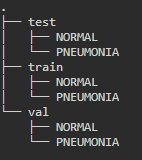

- 디렉토리(train, val, test)의 각 파일(image)의 경로들을 리스트에 담아서 데이터셋의 갯수 파악
    - train : 5216
    - val : 16
    - test : 624
- val data가 너무 적음 -> train, val 데이터를 모아 8:2로 다시 나눠줌
    - train : 4185
    - val : 1047
    - test : 624
- 디렉토리 이름(NORMAL, PNUMONIA)을 통해 train data 비율 확인
    - Normal images count in training set: 1070
    - Pneumonia images count in training set: 3115
    - imbalance! -> **class balancing 필요할 수 있음**
    - test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.
- mini-batch 작업을 위한 tf.data 인스턴스 생성
- tf.data 인스턴스에 담긴 Train 데이터셋, validation 데이터셋 개수 확인
    - train : 4185
    - val : 1047

In [3]:
# tf.io.gfile.glob() : 파일 경로 패턴에 매칭되는 파일들을 찾아 리스트로 반환

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train, test, val 데이터 갯수 확인
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- validation data가 너무 적음 -> train dataset에서 가져와서 8:2정도로 만들어줌

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8) # 비율 설정
random.seed(8)                              # 랜덤시드 설정
random.shuffle(filenames)                   # train+val을 섞어줌
train_filenames = filenames[:train_size]    # train 할당
val_filenames = filenames[train_size:]      # val 할당

# 다시 나눈 데이터 갯수 확인
print(len(train_filenames))
print(len(val_filenames))
print(len(test_filenames))

4185
1047
624


In [5]:
# 디렉토리 이름을 통해 train dataset의 정상, 폐럼 이미지 수 확인

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [6]:
# mini-batch 작업을 위한 tf.data 인스턴스 

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# Train 데이터셋, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### (2) labeling을 위한 함수 작성

1. get_label(file_path): 파일의 경로 이름을 받아 폐렴이면 양성(True), 노말이면 음성(False) 리턴
2. 이미지 데이터 조정 : 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해
    1. decode_img(img): image decoding, to float32, reshape([180, 180])
    2. process_path(file_path): get_label( )로 label불러오기, 이미지를 읽고, decode_img( )로 수정 
        - img, label 리턴
     

In [8]:
# **파일 경로의 끝에서 두번째 부분**을 확인하면 양성과 음성을 구분할 수 있습니다

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)         # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)              # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.

def process_path(file_path):
    label = get_label(file_path)     # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img)            # 이미지를 알맞은 형식으로 수정
    return img, label

### (3) train, validation, test 데이터 셋을 만듭니다. 

- num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다

 : AUTOTUNE은 TensorFlow가 자동으로 최적의 병렬처리 수준을 선택하도록 하는 특별한 상수입니다. 이렇게 하면 TensorFlow가 실행 환경에 따라 최적의 성능을 얻을 수 있습니다.
 
-> 위에서 정의한 함수를 각 데이터에 적용해서 

1. 데이터 타입 맞추고
2. 사이즈 맞추고
3. 라벨링
4. 확인

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

for image, label in train_ds.take(1):           # train_ds.take(1)은 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [12]:
# test dataset 만들고 데이터 수 확인

# tf.data instance
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

# 데이터 갯수 확인
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

# 이미지 전처리
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 배치사이즈 설정
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [13]:
# tf.data 파이프라인을 이용하여 `prepare_for_training()` 함수를 정의 -> 데이터 변환

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  # 고정크기 버퍼 유지, 해당버퍼에서 무작위로 균일하게 다음 요소 선택
    ds = ds.repeat()                                  # epoch를 진행하면서 데이터를 불러올 때 여러 번 데이터셋을 사용, 자동으로 데이터 맞춰줌 
    ds = ds.batch(BATCH_SIZE)                         # batch size 설정
    ds = ds.prefetch(buffer_size=AUTOTUNE)            # 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.
    return ds

# 데이터 변환
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


### [ step 2 정리 ]
(1) 파일 load, 갯수확인, 비율 조정<br>
(2) labeling을 위한 함수 작성<br>
(3) 데이터 전처리 1: 이미지 라벨링, 리사이즈, 데이터 셋 만들기<br>
(4) 데이터 전처리 2: 효율적인 training을 위한 설정, batch size 설정<br>

## Step 3. 데이터 시각화
---
데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. <br>
추출된 배치를 image와 label 데이터 셋으로 나눕니다. <br>
이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

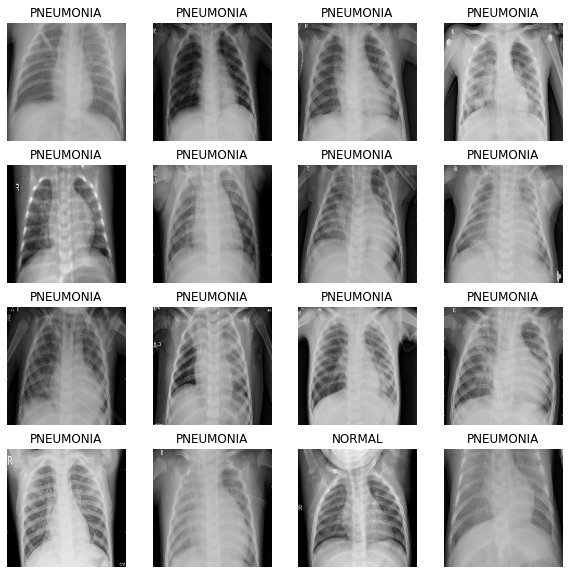

In [14]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1) # BATCH_SIZE = 16
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. ResNet-18 구현
---
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

이번 스텝에서는 ResNet-18 구현을 진행합니다. ResNet은 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델입니다.

ResNet의 특징이라면 Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다는 점입니다. ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용되고 있습니다.

우리는 ResNet의 가장 작은 버전인 ResNet-18로 구현하려고 합니다.

ResNet은 Residual block을 먼저 구성해야 합니다. ResNet에서의 weight layer는

1. 3x3 CNN
2. BatchNormalization
3. 활성화 함수 ReLU

로 구성되어 있습니다.

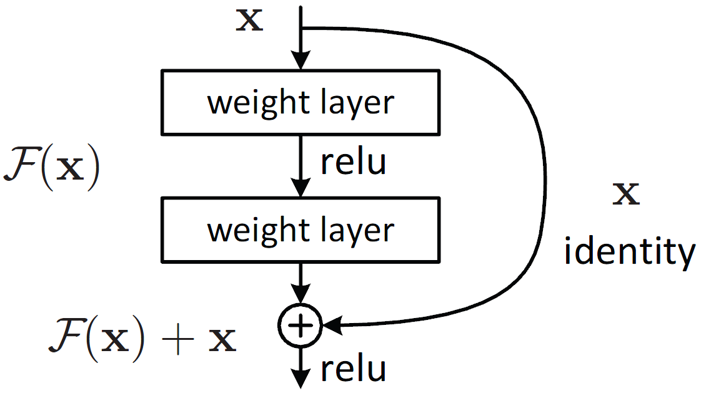

위에 있는 그림대로 Residual block을 구성했다면 이제는 아래 그림을 보고 ResNet을 구현해주세요 (참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿔주세요!)

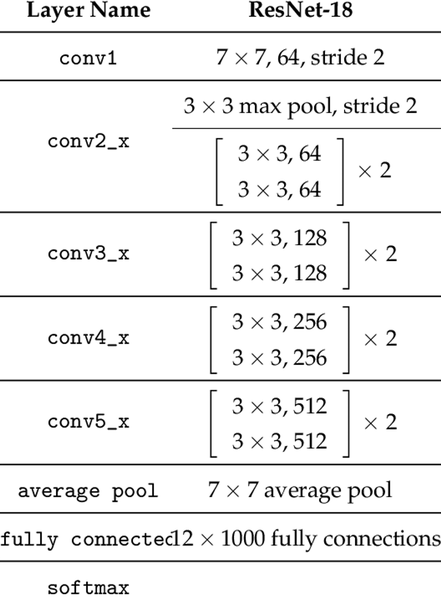


### 참고 : (https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py)

### (1) Residual Block 구성
---
1. 3x3 CNN
2. BatchNormalization
3. 활성화 함수 ReLU

이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.<br>
max pooling을 블락마다 하는게 맞나 고민


>kaiming_normal은 He 초기화([He initialization](https://reniew.github.io/13/))라고도 불리는 초기화 방법 중 하나입니다. 초기화는 신경망 가중치를 적절한 값으로 설정하는 방법으로, 모델의 학습을 개선하고 수렴을 빠르게 만드는 데 도움이 될 수 있습니다.
<br>이 초기화 방법은 주로 ReLU(Rectified Linear Unit)와 같은 활성화 함수와 함께 사용됩니다. <br>[tf.keras.initializers.VarianceScaling](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/VarianceScaling)을 사용하여 He 초기화를 수행하고, scale=2.0, mode='fan_out', distribution='untruncated_normal'과 같은 매개변수를 설정합니다.
<br><br> - scale=2.0: 초기화 된 가중치의 표준 편차를 설정합니다.
<br> - mode='fan_out': 가중치 초기화의 모드를 설정합니다. 'fan_out'은 출력 채널에 의해 나누어짐을 의미합니다.
<br> - distribution='untruncated_normal': 초기화 된 값이 트랙젝션되지 않은 정규 분포를 따르도록 설정합니다.
<br><br>이러한 초기화 방법은 특히 깊은 신경망에서 사용할 때 그레이디언트 소실 및 폭주 문제를 완화하는 데 도움이 될 수 있습니다.

In [15]:
# 모델에 입력할 데이터 모양 확인
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [19]:
import math
from tensorflow import keras
from tensorflow.keras import layers

# initialization
kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

# conv1 block
def conv3x3(x, out_planes, stride=1, name=None):
    # 입력 크기 유지
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    # conv1
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)
    #return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, name=name)(x)


# residual block 정의
def basic_block(x, planes, stride=1, downsample=None, name=None):
    '''
    args
        x: 입력 텐서. Residual 블록의 입력으로 사용됩니다.
        planes: Residual 블록의 출력 채널 수입니다. 이는 블록 내에서 Convolutional 레이어들이 생성하는 특징 맵의 수를 나타냅니다.
        stride: 첫 번째 Convolutional 레이어에서의 stride. 기본값은 1로 설정되어 있습니다.
        downsample: 스킵 연결을 만들기 위해 사용되는 레이어들의 리스트입니다. 만약 스킵 연결이 필요하지 않다면 None으로 설정됩니다.
        name: 블록에 부여되는 이름입니다. 이는 블록 내의 각 레이어에 유니크한 이름을 부여하는 데 사용됩니다.
    '''
    identity = x

    # weight layer 1
    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)  # F(x)
    # weight layer 2
    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)
    
    # Skip connection
    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)
    
    out = layers.Add(name=f'{name}.add')([identity, out]) # F(x) + x
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

# residual block 적용
def make_layer(x, planes, blocks, stride=1, name=None):
    '''
    args
        x: 입력 텐서
        planes: Residual 블록의 출력 채널 수
        blocks: 해당 레이어에 포함될 Residual 블록의 수
        stride: Residual 블록의 첫 번째 Conv2D 레이어에서의 보폭(stride). 기본값은 1.
        name: 레이어의 이름 (옵션)
    '''
    downsample = None
    '''
    downsample 부분은 Residual 블록에서 스킵 연결을 구성하는 부분입니다. 
    만약 스킵 연결이 필요한 경우(즉, stride가 1이 아니거나, 입력 채널 수와 출력 채널 수가 다른 경우)
    -> 1x1 Conv2D 레이어와 BatchNormalization 레이어로 이루어진 스킵 연결을 생성합니다.
    '''
    
    # skip connection이 필요한지 판단
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        # skip connection에 적용되는 layer
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            #layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]
    
    # 이전에 정의한 residual block
    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x


### (2) build model

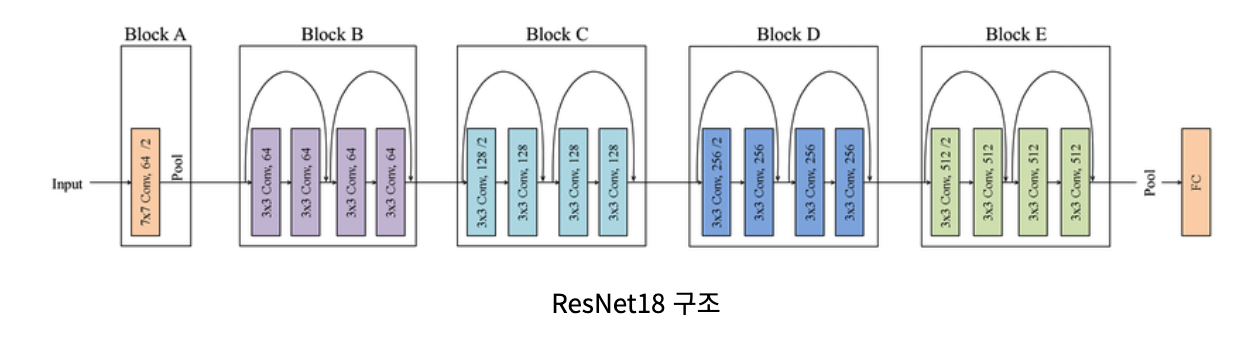

In [20]:
def resnet(x, blocks_per_layer, num_classes=1000):
    # input: conv1
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    #x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    
    # conv2_x
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)
    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    # conv3_x
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    # conv4_x
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    # conv5_x
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')
    # avepool
    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    # fc     
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    #x = layers.Flatten()(x)
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)
    # softmax
    x = layers.Dense(1, activation='softmax')(x)
    
    return x

# resnet18
def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs) # [2, 2, 2, 2] : layer당 사용할 block. ex resnet34: [3, 4, 6, 3]


In [21]:
inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
outputs = resnet18(inputs)
model = keras.Model(inputs, outputs)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 90, 90, 64)   9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 90, 90, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

In [23]:
# Resudual Block 구성

'''
# Convolution block

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block



from keras import layers

def residual_block(x, filters_in, filters_out, k_size):
    '''
    '''
    x : input
    filters_in : 첫 번째 두 개의 Conv2D 레이어에서 사용되는 필터 수
    filters_out : 세 번째 Conv2D 레이어에서 사용되는 필터 수
    (일반적으로 filters_in과 filters_out은 동일한 값을 사용)
    k_size : kernel size
    '''
    '''
    shortcut = x
    #x = layers.Conv2D(filters_in, kernel_size=(1, 1), strides=(1, 1), padding="same")(x)
    #x = layers.BatchNormalization()(x)
    #x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(filters_in, kernel_size=(k_size, k_size), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)    
    
    x = layers.Conv2D(filters_out, kernel_size=(k_size, k_size), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    shortcut_channel = x.shape.as_list()[-1]
    
    # indentity block
    if shortcut_channel != filters_out:
        shortcut = layers.Conv2D(filters_out, kernel_size=(k_size, k_size), padding="same")(shortcut)
        
    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)              #or LeakyReLU()(x)

# Dense Block (fc)
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block
    
'''


IndentationError: unexpected indent (3528700225.py, line 22)

In [24]:
'''
# model build

def build_model:
    model = tf.keras.Sequential([
        # input block
        # 모델의 입력으로 사용할 텐서를 생성
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),          # IMAGE_SIZE = [180, 180]
        
        # conv1
        tf.keras.layers.Conv2D(64, 7, strides=2, activation='relu', padding='same'),
        
        # maxpool
        tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same"),
        
        # conv2_x
        residual_block(x, 64, 64, k_size),
        residual_block(x, 64, 64, k_size),
        
        # conv3_x
        residual_block(x, filters_in, filters_out, k_size),
        residual_block(x, filters_in, filters_out, k_size),
        
        # conv4_x
        residual_block(x, filters_in, filters_out, k_size),
        residual_block(x, filters_in, filters_out, k_size),
        #tf.keras.layers.Dropout(0.2),

        # conv5_x
        residual_block(x, filters_in, filters_out, k_size),
        residual_block(x, filters_in, filters_out, k_size),
        #tf.keras.layers.Dropout(0.2),

        # avePool
        tf.keras.layers.AveragePooling2D(pool_size=(7, 7))
        
        # fully connected
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model
'''

'\n# model build\n\ndef build_model:\n    model = tf.keras.Sequential([\n        # input block\n        # 모델의 입력으로 사용할 텐서를 생성\n        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),          # IMAGE_SIZE = [180, 180]\n        \n        # conv1\n        tf.keras.layers.Conv2D(64, 7, strides=2, activation=\'relu\', padding=\'same\'),\n        \n        # maxpool\n        tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same"),\n        \n        # conv2_x\n        residual_block(x, 64, 64, k_size),\n        residual_block(x, 64, 64, k_size),\n        \n        # conv3_x\n        residual_block(x, filters_in, filters_out, k_size),\n        residual_block(x, filters_in, filters_out, k_size),\n        \n        # conv4_x\n        residual_block(x, filters_in, filters_out, k_size),\n        residual_block(x, filters_in, filters_out, k_size),\n        #tf.keras.layers.Dropout(0.2),\n\n        # conv5_x\n        residual_block(x, filters_in, filters_out, k_size),\n    

In [25]:
# class

'''
class MyModel(keras.Model):
    def __init__(self):
        super().__init__()
        
        # input
        self._input = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))  # IMAGE_SIZE = [180, 180]
        # conv1
        self.conv1 = tf.keras.layers.Conv2D(64, 7, strides=2, activation='relu', padding='same')
        # maxpool
        self.maxpool = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        
        # conv2_x
        self.res2_1 = residual_block(x, 64, 64, 3),
        self.res2_2 = residual_block(x, 64, 64, 3),
        
        # conv3_x
        self.res3_1 = residual_block(x, 128, 128, 3),
        self.res3_2 = residual_block(x, 128, 128, 3),
        
        # conv4_x
        self.res4_1 = residual_block(x, 256, 256, 3),
        self.res4_2 = residual_block(x, 256, 256, 3),
        #self.res4_3 = tf.keras.layers.Dropout(0.2),

        # conv5_x
        self.res5_1 = residual_block(x, 512, 512, 3),
        self.res5_2 = residual_block(x, 512, 512, 3),
        #self.res4_3 = tf.keras.layers.Dropout(0.2),

        # avePool
        self.avepool = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))
        
        # fully connected
        self.flatten = tf.keras.layers.Flatten(),
        output = dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
        
        
        
    def call(self, inputs):
        x = self._input(inputs)
        return self._output(x)

model = MyModel()

'''

'\nclass MyModel(keras.Model):\n    def __init__(self):\n        super().__init__()\n        \n        # input\n        self._input = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))  # IMAGE_SIZE = [180, 180]\n        # conv1\n        self.conv1 = tf.keras.layers.Conv2D(64, 7, strides=2, activation=\'relu\', padding=\'same\')\n        # maxpool\n        self.maxpool = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same")\n        \n        # conv2_x\n        self.res2_1 = residual_block(x, 64, 64, 3),\n        self.res2_2 = residual_block(x, 64, 64, 3),\n        \n        # conv3_x\n        self.res3_1 = residual_block(x, 128, 128, 3),\n        self.res3_2 = residual_block(x, 128, 128, 3),\n        \n        # conv4_x\n        self.res4_1 = residual_block(x, 256, 256, 3),\n        self.res4_2 = residual_block(x, 256, 256, 3),\n        #self.res4_3 = tf.keras.layers.Dropout(0.2),\n\n        # conv5_x\n        self.res5_1 = residual_block(x, 512, 512, 3),\n      

## Step 5. 데이터 imbalance 처리
---
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

pneumonia가 normal보다 3배 많았음 -> imbalance -> 학습효과 안좋음

이런 문제들을 해결하는 방법으로 `Weight balancing`이라는 테크닉이 사용됩니다. 

`Weight balancing` : training set의 각 데이터에서 `loss`를 계산할 때 **특정 클래스의 데이터**에 **더 큰 loss 값을 갖도록 가중치를 부여**하는 방법입니다. 
- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 `class_weight` 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 상세한 내용은 아래 링크를 참고합시다.

[딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)

아래 코드에서 
- `weight_for_0`은 'Normal' 이미지에 사용할 weight를, 
- `weight_for_1`은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 

이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다

In [26]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련
---
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

- 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 `GPU를 선택`합니다. 
- 모델은 위에서 만들었던 모델 함수인 `build_model()을 model에 선언`합니다.

이미지의 라벨이 두 개밖에 없기 때문에 
- `"binary_cross entropy" loss`를 사용합니다. 
- `optimizer로 'adam'`을 사용합니다.
- metrics으로 `'accuracy'`, `'precision'`, `'recall'`을 사용합니다.

In [27]:
# 디바이스 설정

with tf.device('/GPU:0'):
    # 모델 정의
    model = model
    
    # metric 정의
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    # optimizer, loss, meteric
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [28]:
# fit

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=5,     #test epoch 1 || EPOCHS
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 [==============================] - 64s 195ms/step - loss: 0.4006 - accuracy: 0.7438 - precision: 0.7438 - recall: 1.0000 - val_loss: 4.2705 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 50s 194ms/step - loss: 0.2358 - accuracy: 0.7447 - precision: 0.7447 - recall: 1.0000 - val_loss: 0.3996 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 51s 196ms/step - loss: 0.2004 - accuracy: 0.7445 - precision: 0.7445 - recall: 1.0000 - val_loss: 4.5911 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 52s 199ms/step - loss: 0.1437 - accuracy: 0.7455 - precision: 0.7455 - recall: 1.0000 - val_loss: 0.4116 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 5/5
261/261 [==============================] - 53s 203ms/step - loss: 0.1317 - accuracy: 0

## Step 7. 결과 확인과 시각화
---
테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

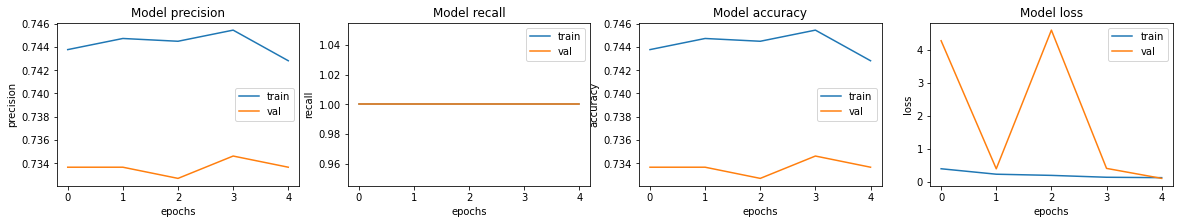

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
history.history['accuracy']

[0.7437739372253418,
 0.7447317838668823,
 0.7444923520088196,
 0.7454501986503601,
 0.7428160905838013]

### 테스트 데이터로 모델 평가

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력

In [31]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 117ms/step - loss: 0.8450 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.8450236320495605,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


이제 여러분들도 페렴 진단에 있어서 약 80% 정도는 맞출 수 있게 되었습니다.
의사분들이 90% 이상이시니 거의 비슷한 실력이라기에는 다소 모자라는 느낌은 있지만 의료 보조 용도로는 어느 정도 쓸만한 모델이라고는 할 수 있겠습니다.

그럼 **성능을 좀 더 개선해볼 수 있는 방법**은 없을까요?
오늘 우리가 다룬 폐렴 데이터를 기반으로 한 연구도 많이 찾아볼 수 있습니다.

의료 데이터의 경우 구하기도 어렵고 구하더라도 데이터가 작은 경우가 많이 있습니다. 이런 문제를 해결하기 위해 **Data augmentation 방법**을 많이 시도합니다.

`Data augmentation` 은 각 데이터에 최적화된 방법을 찾기가 어렵고 제약사항이 많습니다. 그래서 의료분야에서는 <U>기본적인</U> Data augmentation 방법들을 많이 사용합니다. `이미지 회전`, `가우시안 노이즈 추가 방법` 등을 많이 사용합니다. 특히 **장기의 크기는 사람마다 거의 바뀌지 않습니다.** 이런 특성을 이용한 방법이 노이즈 추가 방법입니다.

전통적인 Data augmentation 방법 이외에도 `GAN`을 이용해서 Data augmentation을 시도하는 연구들도 많이 있으니 참고하시면 좋을 것 같습니다.

## 회고
---

혼자 resnet 구조 짜려다가 다른데서 퍼와서 수정하면서 맞춰보는데 한세월걸렸다<br>
모델 돌아간다! 했는데 학습이 전혀 안되서<br>
원인찾다가 timeout ㅠ
